In [1]:
import pandas as pd
import numpy as np

Monte Carlo methods are powerful tools that we can use to predict a range of potential values for some random event using repeated sampling with replacement.  They can be used in business problems where we want to have a reasonable distribution of values for a business prediction. 

### Business Problem 

Suppose that we are a corporation and we are trying to figure out how much money to budget for sales commissions during the next year.  How in the world can we come up with any reasonable estimation of this number? Ideally, we want to be as accurate as possible, so that the company doesn't waste money. This is where the power of Monte Carlo really shines.  By using Monte Carlo methods, we can sample from our sales distribution, and because of the central limit theorem, we can build a normal distribution of results and use the properties of a normal distribution to make predictions. 

### Monte Carlo 

In order to implement Monte Carlo simulating, we have to think about our problem.  We want to model how much we will pay yearly in commission rates, so we need some knowledge about what the expected commission rate is.  Since we are a business and have been around for a while, we have data we can use about our historical commission payouts.  Suppose we know that the commissions are roughly normally distributed with a mean of 100% and a standard deivation of 10%.  

### Building a Model 

Knowing this, we have everything we need to build our model.  Let's first define our model parameters.  We will assume that there are 500 representatives at our company and we will simulate this 1000 times: 

In [2]:
# Model parameters
avg = 1
std_dev = .1
num_reps = 500
num_simulations = 1000

Let's create an array of percentages that replicate the historical normal distribution of our commission percentages:  

In [3]:
# Historical target performance percentages
pct_to_target = np.random.normal(avg, std_dev, num_reps).round(2)

And just to check, let's see a few of the values: 

In [4]:
pct_to_target[:5]

array([1.02, 1.  , 1.1 , 1.06, 1.1 ])

Ok, so this looks alright.  Another value we will need to simulate is the sales target distribution, which is the distribution of what the yearly sales goal of our representatives was.  A likely scenario might be an exponential distribution, where the vast majority of representatives have something like a \\$75,000 yearly goal, with buckets for \\$100,000, \\$200,000, and so on having increasingly fewer representatives. For the purpose of this notebook, we will model this as a uniform distribution, but assign a lower probability to the higher values. 

In [5]:
# Sales targets and probabilities for each target
sales_target_values = [75000, 100000, 200000, 300000, 400000, 500000]
sales_target_prob = [.3, .3, .2, .1, .05, .05]
sales_target = np.random.choice(sales_target_values, num_reps, p=sales_target_prob)

So now that we have two of our features we need, we can build up our DataFrame: 

In [6]:
df = pd.DataFrame(index=range(num_reps), data={'Pct_To_Target': pct_to_target,
                                               'Sales_Target': sales_target})

df['Sales'] = df['Pct_To_Target'] * df['Sales_Target']

Let's see how this looks: 

In [7]:
df.head()

,Pct_To_Target,Sales_Target,Sales
0,1.02,75000,76500.0
1,1.00,100000,100000.0
2,1.10,75000,82500.0
3,1.06,100000,106000.0
4,1.10,100000,110000.0


The final thing we need is a mapping to return the commission a representative should receive based upon what her/his percentage to the target was:

In [8]:
def commission_rate(x):
    """
    Return a commission rate based on the following: 
    0-90% sales = 2%
    91-99% sales = 3%
    100%+ sales = 4%
    """
    if x <= .90: 
        return .02
    elif x < .99:
        return .03
    else: 
        return .04

We now take this function and create a new column for the commission rate and apply it to the percentage to target column: 

In [9]:
df['Commission_Rate'] = df['Pct_To_Target'].apply(commission_rate)
df['Commission_Amount'] = df['Commission_Rate'] * df['Sales']
df.head()

,Pct_To_Target,Sales_Target,Sales,Commission_Rate,Commission_Amount
0,1.02,75000,76500.0,0.04,3060.0
1,1.00,100000,100000.0,0.04,4000.0
2,1.10,75000,82500.0,0.04,3300.0
3,1.06,100000,106000.0,0.04,4240.0
4,1.10,100000,110000.0,0.04,4400.0


So what was the final sum of our commission that we would pay in this model? 

In [10]:
df['Commission_Amount'].sum()

2953122.5

### Simulating Many Times 

Great! So we see that our final commission payout was around \\$2,863,000.  That gives us a much better sense of how much we might expect to payout based on our model parameters.  But one measurement based upon random inputs is not necessarily indicative of anything.  How do we know it's not \\$1,000,000 greater? This is where Monte Carlo steps in.  We can simulate this calculation over and over as many times as we want and come up with a distribution of values, then take the mean value of our distribution!

In [11]:
# Create results list to store our simulation results
results = []

# Loop through our range of simulations 
for i in range(num_simulations):
    
    # Choose random inputs for sales_target and pct_to_target
    sales_target = np.random.choice(sales_target_values, num_reps, p=sales_target_prob)
    pct_to_target = np.random.normal(avg, std_dev, num_reps).round(2)
    
    # Build the dataframe based on the inputs and number of reps
    df = pd.DataFrame(index=range(num_reps), data={'Pct_To_Target': pct_to_target,
                                                   'Sales_Target': sales_target})

    # Back into the sales number using the percent to target rate
    df['Sales'] = df['Pct_To_Target'] * df['Sales_Target']

    # Determine the commissions rate and calculate it
    df['Commission_Rate'] = df['Pct_To_Target'].apply(commission_rate)
    df['Commission_Amount'] = df['Commission_Rate'] * df['Sales']

    # We want to track sales,commission amounts and sales targets over all the simulations
    results.append([df['Sales'].sum().round(0),
                      df['Commission_Amount'].sum().round(0),
                      df['Sales_Target'].sum().round(0)])

Now let's create a new DataFrame and analyze the results: 

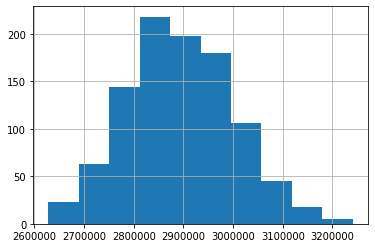

In [14]:
# Results DataFrame
results_df = pd.DataFrame(results, columns=['Sales', 'Commission_Amount', 'Sales_Target'])
results_df['Commission_Amount'].hist()

In [13]:
results_df.describe().style.format('{:,}')

,Sales,Commission_Amount,Sales_Target
count,"1,000.0","1,000.0","1,000.0"
mean,"83,798,515.25","2,894,079.847","83,792,225.0"
std,"2,825,797.0785841006","108,059.3365063926","2,772,697.788689276"
min,"75,161,500.0","2,628,195.0","74,500,000.0"
25%,"81,840,562.5","2,819,057.5","81,918,750.0"
50%,"83,666,625.0","2,889,585.0","83,687,500.0"
75%,"85,729,500.0","2,969,055.5","85,650,000.0"
max,"93,148,500.0","3,241,065.0","93,350,000.0"


So what do the results tell us? The average commissions expense is about \\$2,900,000, with a standard deviation of about \\$108,000.  The max commissions payment was about \\$3,240,000, while the lowest was about \\$2,630,000.  Based on this, if somebody were to say "Let's only budget \\$3,000,000 for commissions", we would probably not feel very good about this, knowing the results of our Monte Carlo simulation.  